# Радиально-базисные нейронные сети.

Радиально-базисной нейронной сетью (РБН) принято называть нейронную сеть, имеющую следующую архитектуру: входной слой с n нейронами ($n$ — размерность векторов-входов), один скрытый слой с $m$ нейронами ( $m \le n$ ) и выходной слой, сеть полносвязная.

![img](https://basegroup.ru/sites/default/files/pic2.gif)

Почему же такие сети выделяются в особый класс? Причина в функциях активации нейронов единственного скрытого слоя. В качестве функций активации выбираются _радиально-базисные функции_ — отсюда и название.

### Радиально-базисные функции

Их характерное свойство заключается в том, что отклик функции монотонно убывает или возрастает с удалением от центральной, базисной точки, то есть РБФ — вещественная функция, зависящая только от _расстояния_ между аргументом x и некоей заданной точкой c : $\;\phi_c (x) = \phi(\|x - c\|)$

Типичный пример такой функции – функция Гаусса, для скалярного аргумента записывающаяся следующиим образом:

$$h(x) = exp\Bigl(-\dfrac{(x-c)^2}{r^2}\Bigr)$$

В случае, когда аргументом является вектор, функция Гаусса запишется так:

$$h(\vec x) = exp\Bigl(-\dfrac{\|  \vec x-\vec c \| ^2}{r^2}\Bigr),$$

где $ \|x \| = \sqrt{\sum\limits_{i=1}^{n} |x_i|^2}, \; x = \bigl( x_1, x_2, \dots, x_n\bigr) $ — привычная Вам евклидова норма.



В этих выражениях $r$ - параметр, от значения которого зависит "ширина" функции: чем ближе (в нашем случае, ближе в терминах евклидового расстояния) $x$ к центроиду $c$, тем ближе к единице значение функции $h$; с увеличением этого расстояния (как видите, не имеет значения, в каком направлении мы удаляемся от центроида) значение $h$ уменьшается вплоть до нуля; $r$ определяет размеры области вокург центроида, при попадании в которое значение функции положительно (и, как следствие, определяет, как быстро уменьшается значение $h$ при оттдалении от центроида).

## Обучение РБН

Существенным отличием РБН от похожих на них по структуре перцептронов является процесс обучения. Как Вы уже наверное догадались, в радиально-базисных сетях во время обучения настраиваются не только веса, но и _центроиды_ радиально-базисных функций — функций активации скрытых нейронов, а так же их _смещения_ — $r$.

При фиксированных $c$ и $r$ сеть обучается аналогично перцептрону, но как выбрать центроиды и смещения?

Обратите внимание, значение радиально-базисных функций зависит от __расстояния__ между аргументом и центроидом. Значит, центроиды должны быть из того же векторного пространства, что и входные данные. Вы уже наверное догадались, как проще всего это обеспечить — выбрать центроидами экземпляры данных из обучающей выборки. Сделать это можно разными способами — от случайного выбора до кластеризации. Во втором случае размер скрытого слоя будет совпадать с числом кластеров (количество нейронов в слое равно количеству требуемых центроидов), а за сами центроиды можно принять центроиды получившихся кластеров. То есть на первом этапе часть параметров настраиваются методами обучения __без учителя__, а затем оставшиеся настраиваются __с учителем__. Смещением же логично выбрать, например, среднее расстояние внутри соотвествующего кластера.

Как видите, ничего приниципиально нового для Вас тут нет: другая функция активации и, как следствие, немного другой подход к обучению. А поскольку отдельные составляющие этих этапов Вам уже известны, предлагаем перейти сразу к рассмотрению на примере:

Перед Вами классическая задача классификации — ирисы Фишера.

In [1]:
from sklearn import datasets
from sklearn.cluster import KMeans

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dic_data = datasets.load_iris(as_frame = True)
df = dic_data['frame']
df.head(-1)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
144,6.7,3.3,5.7,2.5,2
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2


Перемешайте данные и разделите их обучающую (130 наблюдений) и тестовую (оставшиеся наблюдения) выборки:

In [ ]:
# your code here

In [3]:
df = df.sample(frac = 1).reset_index(drop = True)

X = df.iloc[:, :-1]
y = df.target

X_train = X[:130]
X_test = X[130:]

y_train = y[:130]
y_test = y[130:]

В рамках этого примера для первого этапа обучения (без учителя, выбор центроидов и смещений) возьмём за основу метод k-средних. Разумеется, Вы и без кластеризации знаете, сколько тут кластеров и какие они, но так ведь будет не всегда. Оцените оптимальное число кластеров k, создайте массив c из k точек — координат кластеров — и массив r той же длины, содержащий для каждого кластера среднее евклидово расстояние до его центра.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

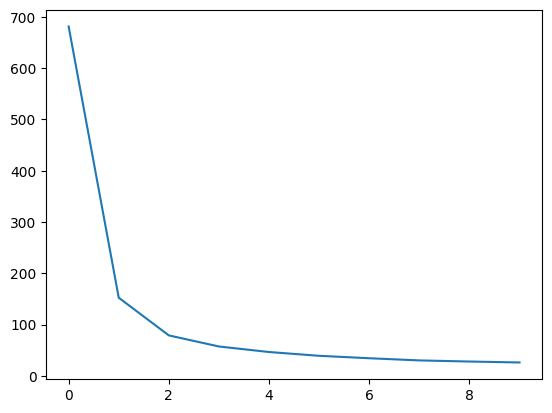

In [4]:
# метод локтя
ssd = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

plt.plot(ssd)

In [8]:
# k
k = 3

kmeans = KMeans(n_clusters = k, random_state = 0)
km_pred = kmeans.fit_predict(X)

# c
c = kmeans.cluster_centers_

# r
r = [np.linalg.norm((X[km_pred == i] - kmeans.cluster_centers_[i])).mean() for i in range(k)]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Мы определились с гиперпараметрами радиально-базисных функций и можем переходить ко второму этапу обучения. Ниже приведена одна из реализаций радиально-базисной сети для классификации. В этой реализации опущено тело метода, возвращающего значений функции активации. Допишите его. Затем создайте экземпляр класса `RBF_`, инициализировав его найденными ранее параметрами, обучите (метод `fit`) и найтиде точность полученного (`predict`) прогноза.

In [9]:
class RBF_:

  def __init__(self, X, y, tX, num_of_classes, centroids, std_list):
      '''
      инициализируем следуюшими переменными:
      X — обучающая выборка
      y — указания учителя
      tX — тестовая выборка
      num_of_classes — количество центроидов (нейронов)
      centroids — массив с координатами центроидов в пространстве данных
      std_list — массив радиусов для каждой радиально-базисной функции
      '''
      self.X = X
      self.y = y

      self.tX = tX

      self.number_of_classes = num_of_classes
      self.centroids = centroids
      self.std_list = std_list

  def convert_to_one_hot(self, x, num_of_classes):
      arr = np.zeros((len(x), num_of_classes))
      for i in range(len(x)):
          c = int(x[i])
          arr[i][c] = 1
      return arr

  def rbf(self, x, c, s):
    '''
    Метод возвращает значение функции активации РБН
    '''
    # your code here
    # print(x.size)
    # print(c.size)
    # print(s.size)
    return np.exp(-1 / (2 * s**2) * ((x-c)**2).sum())
    # pass

  def rbf_list(self, X, centroids, std_list):
      RBF_list = []
      for x in X:
          RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
      return np.array(RBF_list)

  def fit(self):
      RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

      self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)
      self.RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

  def predict(self):
      pred_ty = self.RBF_list_tst @ self.w
      pred_ty = np.array([np.argmax(x) for x in pred_ty])
      return(pred_ty)

In [10]:
from sklearn.metrics import accuracy_score
# your code here

Решение:

In [11]:
model = RBF_(X_train.values, y_train.values, X_test.values, num_of_classes = k, centroids = c, std_list = r)

model.fit()

In [12]:
y_pred = model.predict()

In [13]:
accuracy_score(y_test, y_pred)

0.9

## Дополнительное задание:
Ознакомтесь с другими реализациями радиально-базисных сетей. Обратите внимание на параметры RBF-ядра в библиотеке `scikit-learn`. Перепишите класс RBF_ так, чтобы обеспечить возможность принимать за центроиды элементы обучающей выборки. Протестируйте новую модель и ответьте на вопрос: как в таком случае целесообразно выбирать центроиды? А смещения? Какие требования стоит накладывать на выбранные центроиды?

## ZISC


Помимо прочего, радиально-базисные сети легли в основу некоторых нейропроцессоров. Одним из примеров служит чип ZISC036 от IBM. Число 36 в названии означает количество нейронов. Причем благодаря возможности одновременного подключения нескольких чипов, размер сети, по сути, не ограничен 36 нейронами. Количество микро-инструкций сведено к минимуму.

Поскольку в основе РБН лежит приницп сравнения входных данных с образцом (центроидом), эти чипы успешно справляются с классификацией и обработкой изображения и другими задачами, связанными с сопоставлением с образцом. Настолько успешно, что они применялись и 10 лет спустя после первого появления в 2007 году.

![img](https://www.researchgate.net/profile/Kurosh-Madani/publication/268053075/figure/fig1/AS:373526067466240@1466066962622/IBM-ZISC-036-chips-bloc-diagram-Two-kinds-of-registers-hold-information-in-ZISC-O36.png)

![img](https://upload.wikimedia.org/wikipedia/commons/thumb/6/61/HEBB-1_circuit_board.png/1280px-HEBB-1_circuit_board.png?1654430397775)
Как уже было сказано выше, чип во многом повторяет архитектуру РБН. Его нужно _обучать_ (в классическом нейросетевом понимании, с учителем) на данных, после чего за счет хорошей параллельности обработки, с его помощью можно решать многие из описанных выше задач в реальном времени. Что до гибкости: поддерживается 2 метода подсчета _расстояния_
между объектами (напомним, это основной аргумент радиально-базисной функции), есть специальный режим для кластеризации объектов по методу k ближайших соседей.